# Design Flowsheet for NGCC + SOEC with Steam Integration

This flowsheet example provides an off-design model for integration of an SOEC for hydrogen production with an NGCC.  The NGCC nominally produces 650 MW net, and includeds 97% CO2 capture.  A detailed SOEC unit model is used here.

## Import Required Modules

In [1]:
import os
import math
import numpy as np
import pytest
from IPython.core.display import SVG
import pyomo.environ as pyo
from idaes.core.solvers import use_idaes_solver_configuration_defaults
import idaes
import idaes.core.util.scaling as iscale
from idaes.core.util import model_serializer as ms
import idaes.core.util as iutil
import ngcc_soec_costing ### changed name of costing module
from idaes.models_extra.power_generation.costing.power_plant_capcost import (
    QGESSCosting,
    QGESSCostingData,
)
import ngcc_soec

## Make Output Directories

This notebook can produce a large number of output files.  To make it easier to manage, some subdirectories are used to orginize output.  This ensures that the drectories exist.

In [2]:
def make_directory(path):
    """Make a directory if it doesn't exist"""
    try:
        os.mkdir(path)
    except FileExistsError:
        pass
    
make_directory("data")
make_directory("data_pfds")
make_directory("data_tabulated")

## Set Global Solver Options

Setting global solver options applies them to any solver created subsequently, including the ones used for initialization.  The user scaling option disables Ipopt's automatic scaling and allows it to use user provided variable scaling.

In [3]:
use_idaes_solver_configuration_defaults()
idaes.cfg.ipopt.options.nlp_scaling_method = "user-scaling"
idaes.cfg.ipopt.options.linear_solver = "ma57"
idaes.cfg.ipopt.options.OF_ma57_automatic_scaling = "yes"
idaes.cfg.ipopt.options.ma57_pivtol = 1e-5
idaes.cfg.ipopt.options.ma57_pivtolmax = 0.1
idaes.cfg.ipopt.options.tol = 1e-3
idaes.cfg.ipopt.options.max_iter = 100
solver = pyo.SolverFactory("ipopt")

## Create and Initialize the NGCC + SOEC Model

In [4]:
if os.path.exists("NGCC_flowsheet_solution.json.gz"):
    # create the ngcc model
    m = pyo.ConcreteModel()
    m.fs = ngcc_soec.NgccSoecFlowsheet(dynamic=False)
    iscale.calculate_scaling_factors(m)
    m.fs.initialize(
        load_from="ngcc_soec_init.json.gz",
    save_to="ngcc_soec_init.json.gz")
    m.fs.ngcc.fuel_cost.fix(4.42)
    m.fs.ngcc.cap_specific_reboiler_duty.fix(2.4e6)
    m.fs.ngcc.cap_fraction.fix(0.97)

    # add capital costing
    m.fs.costing = QGESSCosting()
    ngcc_soec_costing.add_results_for_costing(m)
    ngcc_soec_costing.get_ngcc_soec_capital_cost(m, CE_index_year="2018")

    # load results from json
    print("Loading prior solved results")
    ms.from_json(m, fname="NGCC_flowsheet_solution.json.gz")
else:
    # create the ngcc model
    m = pyo.ConcreteModel()
    m.fs = ngcc_soec.NgccSoecFlowsheet(dynamic=False)
    iscale.calculate_scaling_factors(m)
    m.fs.initialize(
        load_from="ngcc_soec_init.json.gz",
        save_to="ngcc_soec_init.json.gz")
    print("Solve initial problem")
    res = solver.solve(m, tee=True)
    print("Fix fuel cost and resolve")
    m.fs.ngcc.fuel_cost.fix(4.42)
    res = solver.solve(m, tee=True)
    print("Fix reboiler duty and resolve")
    m.fs.ngcc.cap_specific_reboiler_duty.fix(2.4e6)
    res = solver.solve(m, tee=True)
    print("Fix capture fraction and resolve")
    m.fs.ngcc.cap_fraction.fix(0.97)
    res = solver.solve(m, tee=True)

    # add capital costing
    print("Add initial costing and resolve")
    m.fs.costing = QGESSCosting()
    ngcc_soec_costing.add_results_for_costing(m)
    res = solver.solve(m, tee=True)
    print("Add capital costing and resolve")
    ngcc_soec_costing.get_ngcc_soec_capital_cost(m, CE_index_year="2018")
    res = solver.solve(m, tee=True)
    print("Saving results to json")
    ms.to_json(m, fname="NGCC_flowsheet_solution.json.gz")

2022-10-26 10:13:00 [INFO] idaes.init.fs: NGCC/SOEC design load initial from ngcc_soec_init.json.gz
Loading prior solved results


In [5]:
def display_pfd():
    print("\n\nGas Turbine Section\n")
    display(SVG(m.fs.ngcc.gt.write_pfd()))
    print("\n\nHRSG Section\n")
    display(SVG(m.fs.ngcc.hrsg.write_pfd()))
    print("\n\nSteam Turbine Section\n")
    display(SVG(m.fs.ngcc.st.write_pfd()))
    print("\n\nSOEC Section\n")
    display(SVG(m.fs.soec.write_pfd()))

In [6]:
m.fs.ngcc.net_power_mw.display()
m.fs.ngcc.st.steam_turbine.throttle_valve[1].deltaP.display()

net_power_mw : Size=1, Index=fs._time, Units=MW
    Key : Lower : Value             : Upper : Fixed : Stale : Domain
    0.0 :  None : 620.8334199629691 :  None : False : False :  Reals
deltaP : Size=1, Index=fs._time, ReferenceTo=fs.ngcc.st.steam_turbine.throttle_valve[1].control_volume.deltaP
    Key : Lower : Value              : Upper : Fixed : Stale : Domain
    0.0 :  None : -3734573.558023373 :  None : False : False :  Reals


In [7]:
decision_vars = []
def make_decision_var(v, lb, ub):
    v.unfix()
    v.setlb(lb)
    v.setub(ub)
    decision_vars.append(v)

# Add constraints for optimization
m.fs.ngcc.st.steam_turbine.throttle_valve[1].deltaP.setub(-1e5)
m.fs.soec.sweep_recycle_split.mixed_state[0].mole_frac_comp["O2"].setub(0.35)
m.fs.soec.feed_recycle_split.mixed_state[0].mole_frac_comp["H2O"].setlb(0.20)
m.fs.soec.sweep_recycle_split.mixed_state[0].temperature.setub(1030)
m.fs.soec.feed_recycle_split.mixed_state[0].temperature.setub(1030)
m.fs.ngcc.st.steam_turbine_lp_split.mixed_state[0].pressure.setlb(2.9e5)

@m.fs.Constraint(m.fs.time)
def makeup_water_constraint(b, t):
    return m.fs.soec.water_pump.inlet.flow_mol[t] == m.fs.soec.feed_hx01.tube_inlet.flow_mol[t]

# make sure the delta T on the hydrogen side is 40K or less (it's 
# squared so one constraint covers both positive and negative delta T)
@m.fs.Constraint(m.fs.time)
def delta_T_h_constraint(b, t):
    return (
        m.fs.soec.feed_heater.control_volume.properties_out[t].temperature -
        m.fs.soec.feed_recycle_split.mixed_state[t].temperature
    )**2/100 <= 16

# make sure the delta T on the oxygen side is 40K or less
@m.fs.Constraint(m.fs.time)
def delta_T_o_constraint(b, t):
    return (
        m.fs.soec.sweep_heater.control_volume.properties_out[t].temperature -
        m.fs.soec.sweep_recycle_split.mixed_state[t].temperature
    )**2/100 <= 16

# make sure the oxygen inlet and hydrogen outlet are 40K or less apart
@m.fs.Constraint(m.fs.time)
def delta_T_1_constraint(b, t):
    return (
        m.fs.soec.sweep_heater.control_volume.properties_out[t].temperature -
        m.fs.soec.feed_recycle_split.mixed_state[t].temperature
    )**2/100 <= 16

# make sure the hydrogen inlet and oxygen outlet are 40K or less apart
@m.fs.Constraint(m.fs.time)
def delta_T_2_constraint(b, t):
    return (
        m.fs.soec.feed_heater.control_volume.properties_out[t].temperature -
        m.fs.soec.sweep_recycle_split.mixed_state[t].temperature
    )**2/100 <= 16

@m.fs.Constraint(m.fs.time)
def average_current_density_constraint(b, t):
    return m.fs.soec.soec_module.solid_oxide_cell.average_current_density[0]/1000 >= -8

m.fs.soec.water_pump.inlet.flow_mol.unfix()
make_decision_var(m.fs.soec.sweep_recycle_split.split_fraction[0, "out"], 0.50, 0.97)
make_decision_var(m.fs.soec.feed_recycle_split.split_fraction[0, "out"], 0.50, 0.98) 
make_decision_var(m.fs.soec.water_split.split_fraction[0, "outlet1"], 0.3, 0.7)
make_decision_var(m.fs.soec.sweep_compressor.inlet.flow_mol[0], 100, 8000)
make_decision_var(m.fs.soec.soec_module.potential_cell[0], 1.26, 1.38)
make_decision_var(m.fs.soec.feed_heater.control_volume.properties_out[0].temperature, 900, 1020)
make_decision_var(m.fs.soec.sweep_heater.control_volume.properties_out[0].temperature, 900, 1020)
make_decision_var(m.fs.soec.sweep_heater.control_volume.properties_out[0].temperature, 900, 1020)
make_decision_var(m.fs.soec.soec_module.number_cells, 1e6, 2e6)
make_decision_var(m.fs.soec.sweep_hx.area, 2000, 7000)
make_decision_var(m.fs.soec.feed_hx01.area, 2000, 7000)
make_decision_var(m.fs.soec.water_heater01.area, 2000, 7000)
make_decision_var(m.fs.soec.water_heater02.area, 2000, 7000)

m.fs.obj_design = pyo.Objective(
    expr=(
        m.fs.ngcc.total_variable_cost_rate[0] + 
        m.fs.soec.variable_makeup_water_cost[0] +
        (m.fs.ngcc.net_power[0] + m.fs.soec.total_electric_power[0])/1e6 * 100 +
        m.fs.costing.total_TPC*1e6 * 1.093 * 0.0707 * 1.341 / 365 / 24 # anualized cap. + fixed O&M for SOEC part
    )/1e3
)

In [8]:
# initial solve for design, limited to 100 iterations
res = solver.solve(m, tee=True)

Ipopt 3.13.2: nlp_scaling_method=user-scaling
tol=0.001
linear_solver=ma57
ma57_pivtol=1e-05
ma57_pivtolmax=0.1
max_iter=100
option_file_name=C:\Users\BRANDO~1\AppData\Local\Temp\tmpqr1iv89f_ipopt.opt

Using option file "C:\Users\BRANDO~1\AppData\Local\Temp\tmpqr1iv89f_ipopt.opt".


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific 

  67  5.1344332e+01 7.74e+00 4.49e+04  -1.0 7.53e+04  -4.7 2.39e-03 4.61e-05h  1
  68  5.1344233e+01 7.74e+00 1.69e+05  -1.0 3.04e+05  -5.2 2.95e-03 3.03e-05h  7
  69  5.1331122e+01 7.71e+00 1.55e+05  -1.0 4.10e+05  -5.7 3.49e-03 4.21e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70  5.1331216e+01 7.71e+00 1.14e+06  -1.0 1.07e+06  -6.1 2.06e-02 1.07e-04h  1
  71  5.1338687e+01 7.69e+00 1.60e+06  -1.0 2.04e+06  -6.6 1.86e-02 2.11e-03h  5
  72  5.1348552e+01 7.67e+00 2.33e+06  -1.0 2.04e+06  -7.1 9.36e-02 2.80e-03h  7
  73  5.1358672e+01 7.65e+00 2.34e+06  -1.0 2.04e+06  -7.6 2.79e-02 2.97e-03h  9
  74  5.1364814e+01 7.64e+00 9.01e+05  -1.0 2.04e+06  -8.1 9.90e-01 1.91e-03h 10
  75  5.1369013e+01 7.62e+00 8.51e+05  -1.0 2.05e+06  -8.5 6.68e-02 1.91e-03h 10
  76  5.1372486e+01 7.61e+00 5.48e+05  -1.0 2.06e+06  -9.0 3.24e-01 1.91e-03h 10
  77  5.1375137e+01 7.59e+00 3.97e+05  -1.0 2.07e+06  -9.5 2.12e-01 2.67e-03h  7
  78r 5.1375137e+01 7.59e+00



Gas Turbine Section



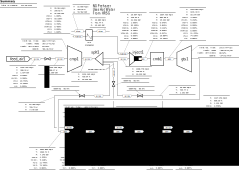



HRSG Section



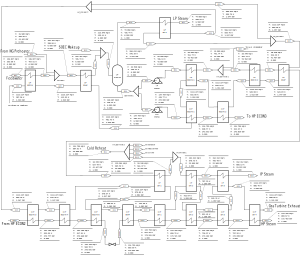



Steam Turbine Section



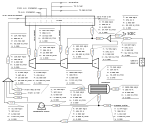



SOEC Section



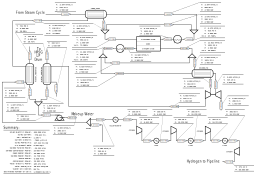

In [9]:
display_pfd()

In [10]:
# Print freed decision vars
for v in decision_vars:
    print(f"{v} {pyo.value(v)}")

print("\n")
print("------------------------------------------")
print("Fixed Costs for Optimized Design")
print("------------------------------------------")

tpc = pyo.value(m.fs.costing.total_TPC)  ### the main costing block is now under fs
tasc = pyo.value(m.fs.costing.total_TPC)*1.21*1.093
ac = tasc*0.0707
print(f"TPC = {tpc}")
print(f"TASC = {tasc}")
print(f"Annualized TASC (MM$/yr) = {ac}")

# Parameters
n_op = 8
hourly_rate = 38.50
labor_burden = 30

# Fixed O&M components
annual_op_labor = n_op * hourly_rate * 8760 * (1 + labor_burden/100)/1e6
maint_labor = tpc * 0.4 * 0.019
maint_material = tpc * 0.6 * 0.019
admin_labor = 0.25*(annual_op_labor + maint_labor)
prop_tax_ins = 0.02*tpc
soec_replace = pyo.value(4.2765*m.fs.soec.soec_module.number_cells)/1e6

print("Fixed O&M Costs")
print(f"annual_op_labor (MM$/yr) = {annual_op_labor}")
print(f"maint_labor (MM$/yr) = {maint_labor}")
print(f"maint_material (MM$/yr) = {maint_material}")
print(f"admin_labor (MM$/yr) = {admin_labor}")
print(f"prop_tax_ins (MM$/yr) = {prop_tax_ins}")
print(f"soec_replace (MM$/yr) = {soec_replace}")
total_fixed = annual_op_labor + maint_labor + maint_material + admin_labor + prop_tax_ins + soec_replace
print(f"Annualized Fixed O&M = {total_fixed}")

print("\n")
print("------------------------------------------")
print("SOEC TPC Breakdown")
print("------------------------------------------")

ngcc_soec_costing.display_capital_costs(m) ### added new function to display the costs from power plant costing

fs.soec.sweep_recycle_split.split_fraction[0.0,out] 0.5333550117792254
fs.soec.feed_recycle_split.split_fraction[0.0,out] 0.5244221826199281
fs.soec.water_split.split_fraction[0.0,outlet1] 0.499920436224871
fs.soec.sweep_compressor.control_volume.properties_in[0.0].flow_mol 5653.031749145706
fs.soec.soec_module.solid_oxide_cell.potential[0.0] 1.2901630804122275
fs.soec.feed_heater.control_volume.properties_out[0.0].temperature 1003.0474415573119
fs.soec.sweep_heater.control_volume.properties_out[0.0].temperature 987.0024937843357
fs.soec.sweep_heater.control_volume.properties_out[0.0].temperature 987.0024937843357
fs.soec.soec_module.number_cells 1092989.1067365534
fs.soec.sweep_hx.area 4027.7294835133494
fs.soec.feed_hx01.area 3975.4704714087893
fs.soec.water_heater01.area 5957.577351637614
fs.soec.water_heater02.area 5970.510017031553


------------------------------------------
Fixed Costs for Optimized Design
------------------------------------------
TPC = 1636.1902557245073
TASC 

In [11]:
# lock in the design vars
m.fs.soec.soec_module.number_cells.fix()
m.fs.soec.sweep_hx.area.fix()
m.fs.soec.feed_hx01.area.fix()
m.fs.soec.water_heater01.area.fix()
m.fs.soec.water_heater02.area.fix()

m.fs.obj_design.deactivate()
m.fs.obj_op = pyo.Objective(
    expr=(
        m.fs.ngcc.total_variable_cost_rate[0] + 
        m.fs.soec.variable_makeup_water_cost[0] +
        (m.fs.ngcc.net_power[0] + m.fs.soec.total_electric_power[0])/1e6 * 100
    )/1e4
)

res = solver.solve(m, tee=True)

Ipopt 3.13.2: nlp_scaling_method=user-scaling
tol=0.001
linear_solver=ma57
ma57_pivtol=1e-05
ma57_pivtolmax=0.1
max_iter=100
option_file_name=C:\Users\BRANDO~1\AppData\Local\Temp\tmp9vsb_b4w_ipopt.opt

Using option file "C:\Users\BRANDO~1\AppData\Local\Temp\tmp9vsb_b4w_ipopt.opt".


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific 



Gas Turbine Section



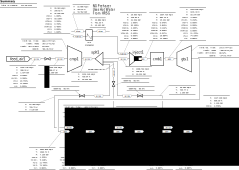



HRSG Section



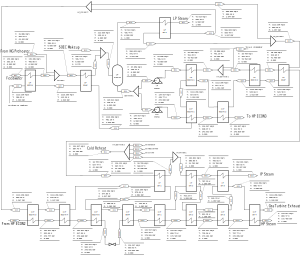



Steam Turbine Section



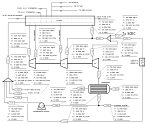



SOEC Section



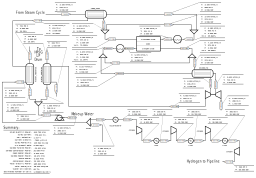

In [12]:
m.fs.ngcc.gt.write_pfd(fname="data_pfds/gt_soec_base.svg")
m.fs.ngcc.hrsg.write_pfd(fname="data_pfds/hrsg_soec_base.svg")
m.fs.ngcc.st.write_pfd(fname="data_pfds/st_soec_base.svg")
m.fs.soec.write_pfd(fname="data_pfds/soec_soec_base.svg")
display_pfd()

m.fs.ngcc.gt.streams_dataframe().to_csv("data_tabulated/ngcc_soec_stream_5kg_gt.csv")
m.fs.ngcc.st.steam_streams_dataframe().to_csv("data_tabulated/ngcc_soec_stream_5kg_st.csv")
m.fs.ngcc.hrsg.steam_streams_dataframe().to_csv("data_tabulated/ngcc_soec_stream_5kg_hrsg_steam.csv")
m.fs.ngcc.hrsg.flue_gas_streams_dataframe().to_csv("data_tabulated/ngcc_soec_stream_5kg_hrsg_gas.csv")
m.fs.soec.streams_dataframe().to_csv("data_tabulated/ngcc_soec_stream_5kg_soec.csv")

### SOEC Performance

In [13]:
print(f"H2 production rate = {m.fs.soec.tags_output['h2_mass_production']}")
print(f"Water flowrate to SOEC = {m.fs.soec.tags_streams['feed02_F']}")
print(f"Stack conversion = {m.fs.soec.tags_output['water_utilization']}"),
print(f"Overall conversion = {m.fs.soec.tags_output['water_utilization_overall']}")
print(f"Number of cells = {m.fs.soec.tags_output['Number_of_cells']}")
print(f"Cell potential = {m.fs.soec.tags_output['cell_potential']}")
print(f"Current density = {m.fs.soec.tags_output['soec_current_density']}")
print(f"SOEC load (AC) = {m.fs.soec.tags_output['soec_power']}")
print(f"Balance of plant load = {m.fs.soec.tags_output['bop_power']}")
print(f"Natural gas flowrate = {m.fs.ngcc.gt.tags_streams['fuel01_F']}")
print(f"Total load = {m.fs.soec.tags_output['total_electric_power']}")
print(f"NGCC net power = {m.fs.ngcc.tags_output['net_power']}")
#print(f"Thermal input = {0}")
print(f"Electric input = {m.fs.soec.tags_output['total_electric_power_per_h2']}")


H2 production rate = 5.000 kg/s
Water flowrate to SOEC = 55.855 kg/s
Stack conversion = 66.7%
Overall conversion = 80.0%
Number of cells = 1.0930e+06 cells
Cell potential = 1.317 V
Current density = -7963.3 A/m**2
SOEC load (AC) = 649.795 MW
Balance of plant load = 40.058 MW
Natural gas flowrate = 25.953 kg/s
Total load = 689.853 MW
NGCC net power = 625.17 MW
Electric input = 38.323 kWh/kg


## Samples

In [14]:
run_samples = False
df = None
if run_samples:
    import pandas as pd
    gt_powers = np.linspace(480., 310., int((480. - 310.)/5.0) + 1).tolist()
    hp_powers = np.linspace(5, 0.75, int((5. - 0.75)/0.25) + 1).tolist()
    
    df = pd.DataFrame(columns=m.fs.tags_output.table_heading())
    i = 1
    save_to_last = None
    for gp in gt_powers:
        gpstr = str(math.ceil(gp))
        m.fs.ngcc.gt.gt_power.fix(-gp*1e6)
        save_to_last_prev = save_to_last
        save_to_last = None
        for hp in hp_powers:
            if hp > 5.001 - 0.25*(480 - gp)/30:
                continue
            m.fs.soec.hydrogen_product_rate.fix(hp)
            hpstr = str(math.ceil(hp*1000))
            save_to = f"data/ngcc_soec_{gpstr}_{hpstr}.json.gz"
            print(save_to)
            if os.path.exists(save_to):
                iutil.from_json(m, fname=save_to, wts=iutil.StoreSpec(suffix=False))                    
                if save_to_last is None:
                    save_to_last = save_to
            else:
                res = solver.solve(m, tee=False)
                if not pyo.check_optimal_termination(res):
                    print("Fail")
                    break
                if save_to_last is None:
                    save_to_last = save_to
                iutil.to_json(m, fname=save_to)
            print(f"Overall net power: {-pyo.value(m.fs.ngcc.net_power[0] + m.fs.soec.total_electric_power[0])/1e6} MW")
            #for v in decision_vars:
            #    print(f"{v} {pyo.value(v)}")
            df.loc[i] = m.fs.tags_output.table_row(numeric=True)
            i += 1
        # go to the closest part of the start of the next series.
        try:
            iutil.from_json(m, fname=save_to_last, wts=iutil.StoreSpec(suffix=False))
        except:
            iutil.from_json(m, fname=save_to_last_prev, wts=iutil.StoreSpec(suffix=False))

In [15]:
if df is not None:
    df.to_csv("data_tabulated/ngcc_soec.csv")